that occur due to storm surges, and on the contributions of changes in MSL to variability in the extremes 

In [1]:
import sys
import pandas as pd
import os

sys.path.append('..')


In [2]:
## This code was copied from https://github.com/philiprt/GeslaDataset/blob/main/gesla.py

import pandas as pd
import xarray as xr
import warnings


class GeslaDataset:
    """A class for loading data from GESLA text files into convenient in-memory
    data objects. By default, single file requests are loaded into
    `pandas.DataFrame` objects, which are similar to in-memory spreadsheets.
    Multifile requests are loaded into `xarray.Dataset` objects, which are
    similar to in-memory NetCDF files."""

    def __init__(self, meta_file, data_path):
        """Initialize loading data from a GESLA database.

        Args:
            meta_file (string): path to the metadata file in .csv format.
            data_path (string): path to the directory containing GESLA data
                files.
        """
        self.meta = pd.read_csv(meta_file)
        self.meta.columns = [
            c.replace(" ", "_")
            .replace("(", "")
            .replace(")", "")
            .replace("/", "_")
            .lower()
            for c in self.meta.columns
        ]
        self.meta.loc[:, "start_date_time"] = [
            pd.to_datetime(d) for d in self.meta.loc[:, "start_date_time"]
        ]
        self.meta.loc[:, "end_date_time"] = [
            pd.to_datetime(d) for d in self.meta.loc[:, "end_date_time"]
        ]
        self.meta.rename(columns={"file_name": "filename"}, inplace=True)
        self.data_path = data_path

    def file_to_pandas(self, filename, return_meta=True):
        """Read a GESLA data file into a pandas.DataFrame object. Metadata is
        returned as a pandas.Series object.

        Args:
            filename (string): name of the GESLA data file. Do not prepend path.
            return_meta (bool, optional): determines if metadata is returned as
                a second function output. Defaults to True.

        Returns:
            pandas.DataFrame: sea-level values and flags with datetime index.
            pandas.Series: record metadata. This return can be excluded by
                setting return_meta=False.
        """
        #with open(self.data_path + filename, "r") as f:
        with open(os.path.join(self.data_path, filename), "r") as f:
            data = pd.read_csv(
                f,
                skiprows=41,
                names=["date", "time", "sea_level", "qc_flag", "use_flag"],
                sep="\s+",
                parse_dates=[[0, 1]],
                index_col=0,
            )
            duplicates = data.index.duplicated()
            if duplicates.sum() > 0:
                data = data.loc[~duplicates]
                warnings.warn(
                    "Duplicate timestamps in file " + filename + " were removed.",
                )
            if return_meta:
                meta = self.meta.loc[self.meta.filename == filename].iloc[0]
                return data, meta
            else:
                return data

    def files_to_xarray(self, filenames):
        """Read a list of GESLA filenames into a xarray.Dataset object. The
        dataset includes variables containing metadata for each record.

        Args:
            filenames (list): list of filename strings.

        Returns:
            xarray.Dataset: data, flags, and metadata for each record.
        """
        data = xr.concat(
            [self.file_to_pandas(f, return_meta=False).to_xarray() for f in filenames],
            dim="station",
        )

        idx = [s.Index for s in self.meta.itertuples() if s.filename in filenames]
        meta = self.meta.loc[idx]
        meta.index = range(meta.index.size)
        meta.index.name = "station"
        data = data.assign({c: meta[c] for c in meta.columns})

        return data

    def load_N_closest(self, lat, lon, N=1, force_xarray=False):
        """Load the N closest GESLA records to a lat/lon location into a
        xarray.Dataset object. The dataset includes variables containing
        metadata for each record.

        Args:
            lat (float): latitude on the interval [-90, 90]
            lon (float): longitude on the interval [-180, 180]
            N (int, optional): number of locations to load. Defaults to 1.
            force_xarray (bool, optional): if N=1, the default behavior is to
                return a pandas.DataFrame object containing data/flags and a
                pandas.Series object containing metadata. Set this argument to
                True to return a xarray Dataset even if N=1. Defaults to False.

        Returns:
            xarray.Dataset: data, flags, and metadata for each record.
        """
        N = int(N)
        if N <= 0:
            raise Exception("Must specify N > 0")

        d = (self.meta.longitude - lon) ** 2 + (self.meta.latitude - lat) ** 2
        idx = d.sort_values().iloc[:N].index
        meta = self.meta.loc[idx]

        if (N > 1) or force_xarray:
            return self.files_to_xarray(meta.filename.tolist())

        else:
            data, meta = self.file_to_pandas(meta.filename.values[0])
            return data, meta

    def load_lat_lon_range(
        self,
        south_lat=-90,
        north_lat=90,
        west_lon=-180,
        east_lon=180,
        force_xarray=False,
    ):
        """Load GESLA records within a rectangular lat/lon range into a xarray.
        Dataset object.

        Args:
            south_lat (float, optional): southern extent of the range. Defaults
                to -90.
            north_lat (float, optional): northern extent of the range. Defaults
                to 90.
            west_lon (float, optional): western extent of the range. Defaults
                to -180.
            east_lon (float, optional): eastern extent of the range. Defaults
                to 180.
            force_xarray (bool, optional): if there is only one record in the
                lat/lon range, the default behavior is to return a
                pandas.DataFrame object containing data/flags and a
                pandas.Series object containing metadata. Set this argument to
                True to return a xarray.Dataset even if only one record is
                selected. Defaults to False.

        Returns:
            xarray.Dataset: data, flags, and metadata for each record.
        """
        if west_lon > 0 & east_lon < 0:
            lon_bool = (self.meta.longitude >= west_lon) | (
                self.meta.longitude <= east_lon
            )
        else:
            lon_bool = (self.meta.longitude >= west_lon) & (
                self.meta.longitude <= east_lon
            )
        lat_bool = (self.meta.latitude >= south_lat) & (self.meta.latitude <= north_lat)
        meta = self.meta.loc[lon_bool & lat_bool]

        if (meta.index.size > 1) or force_xarray:
            return self.files_to_xarray(meta.filename.tolist())

        else:
            data, meta = self.file_to_pandas(meta.filename.values[0])
            return data, meta

<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_85750/372985823.py:61: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+",


In [3]:
meta_file = "/Users/lb962/Downloads/GESLA3_ALL.csv"
data_path = "/Users/lb962/Downloads/GESLA3.0_ALL"
g3 = GeslaDataset(meta_file=meta_file, data_path=data_path)

In [8]:
import os
import numpy as np

#latitudes = [(48, 55), (55,60), (60, 65)]
#longitudes = [(-11.5, -5), (-5, 3), (3, 9), (9, 15)]

latitudes = [(48, 49), (49,50), (50,51), (51,52), (52,53), (54,55), (55,56), (56,57), (57,58), (58,59), (59,60)]
longitudes = [(-11.5, -5), (-5, 3)]
# Define a regular time axis
common_time = pd.date_range(start="1979-01-01", end="2018-12-31 23:00", freq="1H")

output_directory = "/Users/lb962/Documents/GitHub/ESL/data/processed_GESLA"

for lat_range in latitudes:
    for lon_range in longitudes:
        output_file = os.path.join(
            output_directory,
            f"GESLA3_NorthSea_{lat_range[0]}_{lat_range[1]}_{lon_range[0]}_{lon_range[1]}.nc"
        )

        try:
            # Load data
            gesla_data_chunk = g3.load_lat_lon_range(
                south_lat=lat_range[0],
                north_lat=lat_range[1],
                west_lon=lon_range[0],
                east_lon=lon_range[1],
            )

            # Mask sea_level where use_flag is NaN
            mask = np.isnan(gesla_data_chunk["use_flag"])
            sea_level_cleaned = gesla_data_chunk["sea_level"].where(~mask)

            # Convert to float32
            sea_level_cleaned = sea_level_cleaned.astype("float32")

            # Reindex to common time axis, filling missing values with NaN
            sea_level_cleaned = sea_level_cleaned.reindex(date_time=common_time)
            
            # Reindex to a common hourly time axis
            sea_level_cleaned = sea_level_cleaned.reindex(date_time=common_time)
            # Create single-variable dataset
            sea_level_ds = sea_level_cleaned.to_dataset(name="sea_level")
            sea_level_ds["latitude"] = gesla_data_chunk["latitude"]
            sea_level_ds["longitude"] = gesla_data_chunk["longitude"]
            # Save to NetCDF
            sea_level_ds.to_netcdf(output_file)

            print(f"✅ Saved: {output_file}")

        except Exception as e:
            print(f"❌ Failed to save: {output_file}")
            print(f"   Reason: {e}")

❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_49_-11.5_-5.nc
   Reason: index 0 is out of bounds for axis 0 with size 0
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_49_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_49_50_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_49_50_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_50_51_-11.5_-5.nc


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_85750/372985823.py:68: UserWarning: Duplicate timestamps in file arun_platform-arn-gbr-cco were removed.
  warnings.warn(


✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_50_51_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_51_52_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_51_52_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_52_53_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_52_53_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_54_55_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_54_55_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_56_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_56_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_56_57_-11.5_-5.nc
❌ Failed to save: /Users/lb962/Documents

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_85750/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(


✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_57_58_-5_3.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_58_59_-11.5_-5.nc
✅ Saved: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_58_59_-5_3.nc
❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_59_60_-11.5_-5.nc
   Reason: index 0 is out of bounds for axis 0 with size 0
❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_59_60_-5_3.nc
   Reason: index 0 is out of bounds for axis 0 with size 0


In [14]:
import os
import numpy as np

latitudes = [(48, 55), (55,60), (60, 65)]
longitudes = [(-11.5, -5), (-5, 3), (3, 9), (9, 15)]

# Define a regular time axis
common_time = pd.date_range(start="1979-01-01", end="2018-12-31 23:00", freq="1H")

output_directory = "/Users/lb962/Documents/GitHub/ESL/data/processed_GESLA"

for lat_range in latitudes:
    for lon_range in longitudes:
        output_file = os.path.join(
            output_directory,
            f"GESLA3_NorthSea_{lat_range[0]}_{lat_range[1]}_{lon_range[0]}_{lon_range[1]}.nc"
        )

        try:
            # Load data
            gesla_data_chunk = g3.load_lat_lon_range(
                south_lat=lat_range[0],
                north_lat=lat_range[1],
                west_lon=lon_range[0],
                east_lon=lon_range[1],
            )

            # Mask sea_level where use_flag is NaN
            mask = np.isnan(gesla_data_chunk["use_flag"])
            sea_level_cleaned = gesla_data_chunk["sea_level"].where(~mask)

            # Convert to float32
            sea_level_cleaned = sea_level_cleaned.astype("float32")

            # Reindex to common time axis, filling missing values with NaN
            sea_level_cleaned = sea_level_cleaned.reindex(date_time=common_time)
            
            # Reindex to a common hourly time axis
            sea_level_cleaned = sea_level_cleaned.reindex(date_time=common_time)
            # Create single-variable dataset
            sea_level_ds = sea_level_cleaned.to_dataset(name="sea_level")

            # Save to NetCDF
            sea_level_ds.to_netcdf(output_file)

            print(f"✅ Saved: {output_file}")

        except Exception as e:
            print(f"❌ Failed to save: {output_file}")
            print(f"   Reason: {e}")

❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_55_-11.5_-5.nc
   Reason: NetCDF: HDF error


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file arun_platform-arn-gbr-cco were removed.
  warnings.warn(


❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_55_-5_3.nc
   Reason: NetCDF: HDF error


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file delfzijl-delfzl-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file vlissingen-vlissgn-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file hoek_van_holland-hoekvhld-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file den_helder-denhdr-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file harlingen-harlgn-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWar

❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_55_3_9.nc
   Reason: NetCDF: HDF error
❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_48_55_9_15.nc
   Reason: NetCDF: HDF error
❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_-11.5_-5.nc
   Reason: [Errno 13] Permission denied: '/Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_-11.5_-5.nc'


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(


❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_-5_3.nc
   Reason: [Errno 13] Permission denied: '/Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_-5_3.nc'
❌ Failed to save: /Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_3_9.nc
   Reason: [Errno 13] Permission denied: '/Users/lb962/Documents/GitHub/ESL/data/processed_GESLA/GESLA3_NorthSea_55_60_3_9.nc'


KeyboardInterrupt: 

In [7]:
sea_level_cleaned = gesla_data_chunk["sea_level"].where(~mask)

In [5]:
south_lat = 60
north_lat = 65
west_lon = -11.5
east_lon = 15

data1 = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)

#data.to_netcdf("/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/GESLA3_NorthSea_60_65_-11.5_15.nc")

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62445/372985823.py:68: UserWarning: Duplicate timestamps in file maloy-may-nor-nhs were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62445/372985823.py:68: UserWarning: Duplicate timestamps in file kristiansund-ksu-nor-nhs were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62445/372985823.py:68: UserWarning: Duplicate timestamps in file alesund-aes-nor-nhs were removed.
  warnings.warn(


In [15]:
south_lat = 54
north_lat = 60
west_lon = -11.5
east_lon = 15

data2 = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)

#data.to_netcdf("/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/GESLA3_NorthSea_54_60_-11.5_15.nc")

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_84782/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(


: 

In [11]:
south_lat = 50
north_lat = 60
west_lon = -11.5
east_lon = 8

ns_data = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarning: Duplicate timestamps in file arun_platform-arn-gbr-cco were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarning: Duplicate timestamps in file delfzijl-delfzl-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarning: Duplicate timestamps in file vlissingen-vlissgn-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarning: Duplicate timestamps in file hoek_van_holland-hoekvhld-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_81918/372985823.py:68: UserWarnin

: 

In [ ]:
ns_data

In [ ]:
ns_data.to_netcdf("/Users/lb962/Documents/GitHub/ESL/data/processed_full_GESLA/GESLA3_NorthSeaShort.nc")

# quality control

In [2]:
import numpy as np

# Assuming ns_data is your xarray Dataset
sea_level = ns_data["sea_level"]

# Set sea level values to NaN where they are below -1 or above 15
sea_level_filtered = sea_level.where((sea_level > -1) & (sea_level < 15), np.nan)
ns_data["q_sea_level"] = sea_level_filtered

NameError: name 'ns_data' is not defined

#Explore north sea data

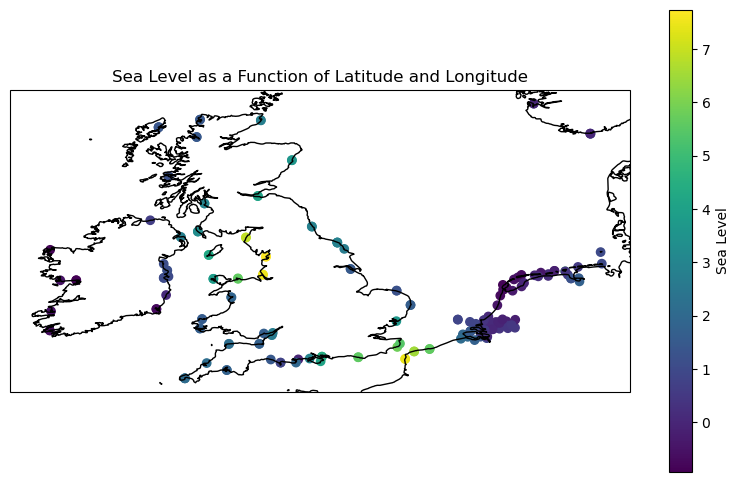

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Choose a specific date
chosen_date = '2014-07-01T15:00:00.000000000'  # Change this to your desired date

# Select data for the chosen date
filtered_ds_chosen_date = ns_data.sel(date_time=chosen_date)

# Assuming filtered_ds_chosen_date is your xarray Dataset
latitude = filtered_ds_chosen_date['latitude'].values.flatten()
longitude = filtered_ds_chosen_date['longitude'].values.flatten()
sea_level = filtered_ds_chosen_date['q_sea_level'].values.flatten()

# Create a Cartopy plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Scatter plot of sea level with latitude and longitude as coordinates
sc = ax.scatter(longitude, latitude, c=sea_level, cmap='viridis')
plt.colorbar(sc, label='Sea Level')

# Add coastlines
ax.coastlines()

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Sea Level as a Function of Latitude and Longitude')
plt.grid(True)
plt.show()


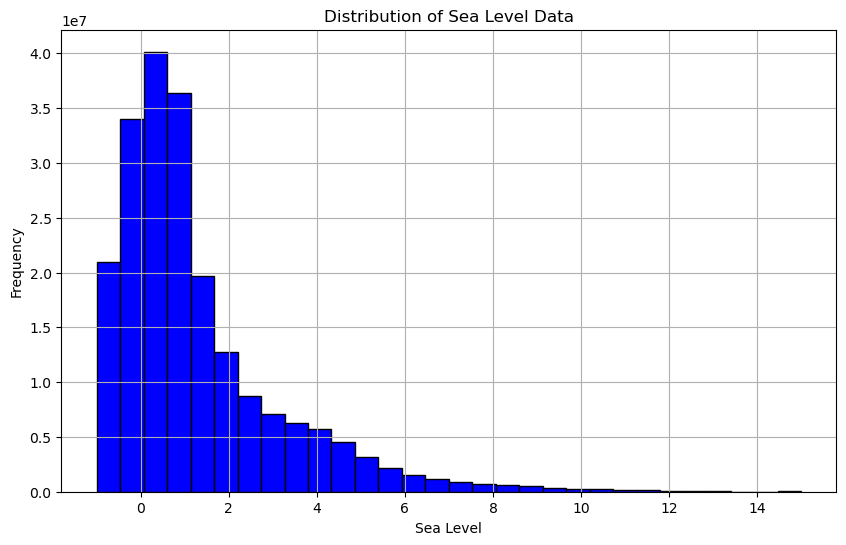

In [33]:
import matplotlib.pyplot as plt

# Assuming ns_data is your xarray Dataset and sea_level is your DataArray
sea_level_data = ns_data.q_sea_level.values.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(sea_level_data, bins=30, color='blue', edgecolor='black')
plt.xlabel('Sea Level')
plt.ylabel('Frequency')
plt.title('Distribution of Sea Level Data')
plt.grid(True)
plt.show()

In [7]:
south_lat = 48
north_lat = 54
west_lon = -11.5
east_lon = 15

data3 = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWarning: Duplicate timestamps in file arun_platform-arn-gbr-cco were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWarning: Duplicate timestamps in file delfzijl-delfzl-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWarning: Duplicate timestamps in file vlissingen-vlissgn-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWarning: Duplicate timestamps in file hoek_van_holland-hoekvhld-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWarning: Duplicate timestamps in file den_helder-denhdr-nld-rws were removed.
  warnings.warn(
/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_62253/372985823.py:68: UserWa

: 

In [9]:
data.to_netcdf("/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/interim/GESLA3_NorthSea_54_60_-11.5_15.nc")

RuntimeError: NetCDF: HDF error

In [5]:
south_lat = 54
north_lat = 60
west_lon = -11.5
east_lon = 15

data = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)

data.to_netcdf("/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/interim/GESLA3_NorthSea_48_54_-11.5_15.nc")

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_61741/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(


## combine all files

In [15]:
import os
import xarray as xr

# Path to the folder containing the NetCDF files
folder_path = "/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA"

# List to store opened datasets
datasets = []

# Iterate over each file in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        # Open the dataset and append it to the list
        dataset = xr.open_dataset(os.path.join(folder_path, file))
        datasets.append(dataset)

# Concatenate the datasets along the time dimension
merged_ds = xr.concat(datasets, dim='time')

# Save the merged dataset to a single NetCDF file
output_file = "/Users/lb962/Downloads/ESL/GESLA/data/processed/merged_GESLA.nc"
merged_ds.to_netcdf(output_file)

In [11]:
!cdo mergetime /Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/*.nc /Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/output_file.nc

cdi  warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable sea_level!
cdi  warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable qc_flag!
cdi  warning (cdfScanVarAttr): Time must be the first dimension! Unsupported array structure, skipped variable use_flag!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable filename!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable site_name!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable site_code!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable country!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable contributor_abbreviated!
cdi  warning (cdf_check_variables): Unsupported data type (char/string), skipped variable contributor_full!
cdi  warning 

## Data from 1 file

In [6]:
filename = "a2-a2-bel-cmems"
data, meta = g3.file_to_pandas(filename)
data

,sea_level,qc_flag,use_flag
date_time,,,
2020-02-28 00:00:00,-0.25,1,1
2020-02-28 00:05:00,-0.21,1,1
2020-02-28 00:10:00,-0.16,1,1
2020-02-28 00:15:00,-0.11,1,1
2020-02-28 00:20:00,-0.06,1,1
...,...,...,...
2021-01-12 08:35:00,0.01,1,1
2021-01-12 08:40:00,0.07,1,1
2021-01-12 08:45:00,0.11,1,1


If you want to work with data from multiple files, and you know the filenames you want, use the function files_to_xarray as follows. The function returns a xarray.Dataset object containing data, flags, and metadata.

In [7]:
filenames = [
    "abrams_river-380-can-meds",
    "acajutla-082c-slv-uhslc", 
    "yoshioka-hd26-jpn-jodc_jcg", 
    "west_point_a_la_hache-8761494-usa-noaa",
]
xr_dataset = g3.files_to_xarray(filenames)
xr_dataset

<xarray.Dataset>
Dimensions:                  (date_time: 289251, station: 4)
Coordinates:
  * date_time                (date_time) datetime64[ns] 1971-06-09T05:00:00 ....
  * station                  (station) int64 0 1 2 3
Data variables: (12/27)
    sea_level                (station, date_time) float64 2.29 1.79 ... nan nan
    qc_flag                  (station, date_time) float64 1.0 1.0 ... nan nan
    use_flag                 (station, date_time) float64 1.0 1.0 ... nan nan
    filename                 (station) object 'acajutla-082c-slv-uhslc' ... '...
    site_name                (station) object 'Acajutla' ... 'Abrams_River'
    site_code                (station) object '082C' 'HD26' '8761494' '380'
    ...                       ...
    datum_information        (station) object 'Unspecified' ... 'Chart Datum ...
    instrument               (station) object 'Unspecified' ... 'Unspecified'
    precision                (station) object 'Unspecified' ... 'Unspecified'
    null_value               (station) float64 -100.0 -100.0 -100.0 -100.0
    gauge_type               (station) object 'Coastal' 'Coastal' ... 'Coastal'
    overall_record_quality   (station) object 'No obvious issues' ... 'No obv...

load data from records close to a particular location using the function load_N_closest as follows. Provide a lat/lon location and the number of desired records. The function returns a xarray.Dataset object containing data, flags, and metadata.

Note the UserWarning that occurs when duplicate timestamps are encountered. The function file_to_pandas used to read each individual file keeps only the first of any duplicate timestamps.

In [8]:
data = g3.load_N_closest(lat=43.83, lon=-65.95, N=10)
print(data.site_name.values)

['Yarmouth' 'Lower_Wedgeport' 'Pinkney_Point' 'Abbotts_Harbour'
 'Clarks_Harbour' 'Woods_Harbour' 'Tusket' 'Abrams_River' 'Flat_Island'
 'Wedgeport']


/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_21477/372985823.py:68: UserWarning: Duplicate timestamps in file yarmouth-365-can-meds were removed.
  warnings.warn(


In [6]:
south_lat = 50
north_lat = 60
west_lon = -12
east_lon = 2

data = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)
print(data.site_name.values)

data

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_8899/372985823.py:68: UserWarning: Duplicate timestamps in file aberdeen-abe-gbr-bodc were removed.
  warnings.warn(


KeyboardInterrupt: 

In [10]:
south_lat = 50
north_lat = 55
west_lon = -6
east_lon = 2

data = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)
print(data.site_name.values)

data

/var/folders/2b/rpgq1g5d5qz2nhbpj5s4jnrc0000gq/T/ipykernel_21477/372985823.py:68: UserWarning: Duplicate timestamps in file arun_platform-arn-gbr-cco were removed.
  warnings.warn(


['Newlyn_Cornwall' 'Newlyn' 'Dover' 'Immingham' 'Milford_Haven'
 'Fishguard' 'Lowestoft' 'Heysham' 'Portpatrick' 'Holyhead' 'Sheerness'
 'Ilfracombe' 'Whitby' 'Avonmouth' 'Newhaven' 'Cromer' 'Harwich'
 'Devonport' 'Hinkley_Point' 'Liverpool_Gladstone_Dock' 'Portsmouth'
 'Weymouth' 'Workington' 'Llandudno' 'Newport' 'Felixstowe'
 'Port_Eri_Isle_of_Man' 'Barmouth' 'Mumbles' 'Bangor' 'Bournemouth'
 'Portbury' 'Herne_Bay' 'Deal_Pier' 'Sandown_Pier' 'Lymington'
 'Swanage_Pier' 'Arun_Platform' 'Port_Isaac' 'West_Bay_Harbour'
 'Scarborough' 'Severn_Bridge' 'Whitby_Harbour' 'Exmouth'
 'Teignmouth_Pier' 'Hastings_Pier' 'Brighton' 'Calais' 'Boulogne_Sur_Mer'
 'Calais_60minute' 'BoulogneSurMer_60minute' 'Lowestoft' 'NorthShields'
 'Newlyn' 'Fishguard' 'Cromer' 'Whitby' 'Immingham' 'Portpatrick' 'Dover'
 'Milford' 'Heysham' 'Newhaven' 'Weymouth' 'Portsmouth' 'Plymouth'
 'Hinkley' 'Liverpool' 'Ilfracombe' 'Workington' 'Barmouth' 'Holyhead'
 'Newport' 'Mumbles' 'Llandudno' 'Sheerness' 'Bangor' 'Avon

<xarray.Dataset>
Dimensions:                  (date_time: 3594814, station: 87)
Coordinates:
  * date_time                (date_time) datetime64[ns] 1915-01-01 ... 2021-0...
  * station                  (station) int64 0 1 2 3 4 5 6 ... 81 82 83 84 85 86
Data variables: (12/27)
    sea_level                (station, date_time) float64 nan nan ... nan nan
    qc_flag                  (station, date_time) float64 nan nan ... nan nan
    use_flag                 (station, date_time) float64 nan nan ... nan nan
    filename                 (station) object 'newlyn_cornwall-294a-gbr-uhslc...
    site_name                (station) object 'Newlyn_Cornwall' ... 'Newhaven'
    site_code                (station) object '294A' 'NEW' 'DOV' ... 'DEV' 'NHA'
    ...                       ...
    datum_information        (station) object 'Unspecified' ... 'Admiralty Ch...
    instrument               (station) object 'Unspecified' ... 'Unspecified'
    precision                (station) object 'Unspecified' ... 'Unspecified'
    null_value               (station) float64 -100.0 -100.0 ... -100.0 -100.0
    gauge_type               (station) object 'Coastal' 'Coastal' ... 'Coastal'
    overall_record_quality   (station) object 'No obvious issues' ... 'No obv...

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [17]:
# Create a Cartopy map
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and sea features with different colors
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot the data points
ax.scatter(data['longitude'], data['latitude'], transform=ccrs.PlateCarree(), label='Cities', color='red', marker='o')

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Stations on the Map')

# Add a legend
ax.legend()

# Show the map
plt.show()

ValueError: Incomplete shapefile definition in '/Users/lb962/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_land.shp'.

<Figure size 640x480 with 1 Axes>

## Explore data format

In [19]:
data

<xarray.Dataset>
Dimensions:                  (date_time: 3594814, station: 87)
Coordinates:
  * date_time                (date_time) datetime64[ns] 1915-01-01 ... 2021-0...
  * station                  (station) int64 0 1 2 3 4 5 6 ... 81 82 83 84 85 86
Data variables: (12/27)
    sea_level                (station, date_time) float64 nan nan ... nan nan
    qc_flag                  (station, date_time) float64 nan nan ... nan nan
    use_flag                 (station, date_time) float64 nan nan ... nan nan
    filename                 (station) object 'newlyn_cornwall-294a-gbr-uhslc...
    site_name                (station) object 'Newlyn_Cornwall' ... 'Newhaven'
    site_code                (station) object '294A' 'NEW' 'DOV' ... 'DEV' 'NHA'
    ...                       ...
    datum_information        (station) object 'Unspecified' ... 'Admiralty Ch...
    instrument               (station) object 'Unspecified' ... 'Unspecified'
    precision                (station) object 'Unspecified' ... 'Unspecified'
    null_value               (station) float64 -100.0 -100.0 ... -100.0 -100.0
    gauge_type               (station) object 'Coastal' 'Coastal' ... 'Coastal'
    overall_record_quality   (station) object 'No obvious issues' ... 'No obv...

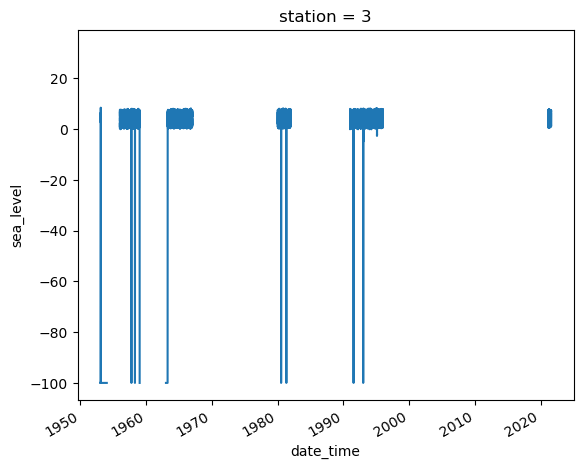

In [20]:
data["sea_level"][3].plot()

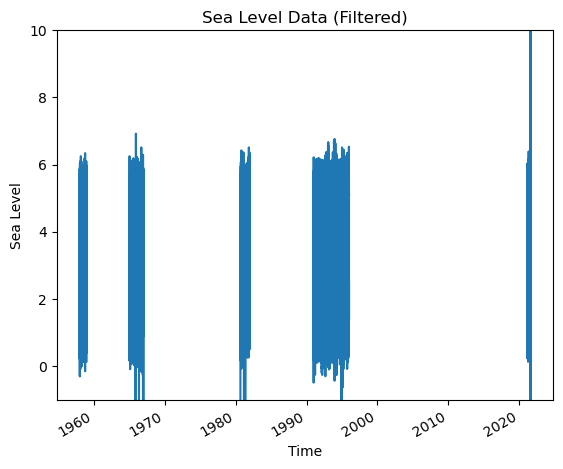

In [165]:
# Assuming data is a DataFrame or another data structure with the "sea_level" dimension
filtered_data = data["sea_level"][10].where((data["sea_level"][3] > -1) & (data["sea_level"][3] < 15))

# Plotting the filtered data
filtered_data.plot()

# Customize the plot as needed
plt.xlabel("Time")
plt.ylabel("Sea Level")
plt.title("Sea Level Data (Filtered)")

# Set the y-axis range
plt.ylim(-1, 10) 

# Show the plot
plt.show()

# Sea level above chart datum

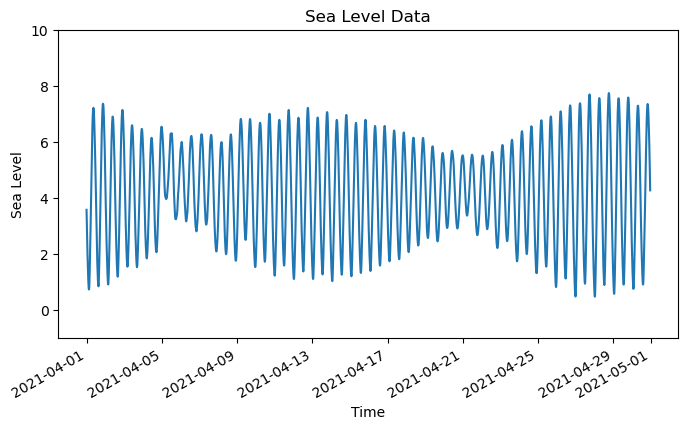

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data is a DataFrame or another data structure with the "sea_level" dimension
start_date = np.datetime64("2021-03-31T23:30:00.000000000")
end_date = np.datetime64("2021-04-30T23:30:00.000000000")

# Filter data based on the time range
filtered_data = data["sea_level"][3].where((data["sea_level"][3] > -1) & (data["sea_level"].date_time >= start_date) & (data["sea_level"].date_time <= end_date))

# Plotting the filtered data
filtered_data.plot(figsize=(8, 4))

# Customize the plot as needed
plt.xlabel("Time")
plt.ylabel("Sea Level")
plt.title("Sea Level Data")

# Set the y-axis range
plt.ylim(-1, 10)

# Show the plot
plt.show()


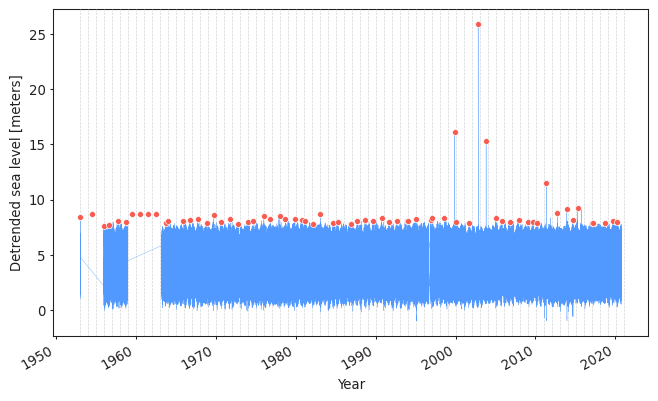

In [153]:
hourly_dataframes
# Plot block maxima
model.plot_extremes()
plt.xlabel("Year")
plt.ylabel("Detrended sea level [meters]")
#plt.savefig("plots/gev/1_annual_block_maxima.png")
plt.show()

In [ ]:
#for station in range(len(data.station)):
hourly_dataframes = []
for station in range(len(data.station[:14])):
    # Assuming data is a DataFrame or another data structure with the "sea_level" dimension
    start_date = data["start_date_time"][station]
    end_date = data["end_date_time"][station]
    
    # Filter data based on the time range
    filtered_SL = data["sea_level"][station].where((data["sea_level"][station] > -1) & (data["sea_level"][3] < 10) & (data["sea_level"].date_time >= start_date) & (data["sea_level"].date_time <= end_date))
    filtered_SL = filtered_SL.to_dataframe()
    latitude = data["latitude"][station].values
    longitude = data["longitude"][station].values
    # Create hourly datetime index from beginning of record to present
    target_dates = pd.date_range("19200101", "20201001", freq="H")
    df_hourly = filtered_SL.dropna().reindex(target_dates)
    df_hourly["latitude"] = latitude
    df_hourly["longitude"] = longitude
    
    # Create a DataFrame with a complete date range for all years
    #complete_years = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq='Y')
    #complete_df = pd.DataFrame(index=complete_years)

    # Merge the complete date range with the original DataFrame
    #df_hourly = complete_df.merge(df_hourly, left_index=True, right_index=True, how='left')

    # Interpolate missing values with a single value for each year
    #single_value = 0
    #df_hourly['sea_level'] = df_hourly['sea_level'].fillna(single_value)

    # Initialize EVA object
    eva_data = df_hourly.sea_level.squeeze()
    model = EVA(data=eva_data)

        # Extract extreme values by annual block maxima approach
    model.get_extremes(
        method="BM",
        extremes_type="high",
        block_size="365.2425D",
        errors="coerce",
    )
      # Fit the model extremes to GEV distribution using MCMC
    model.fit_model(
        model="Emcee",
        #model = "MLE", # alternate model 
        distribution="genextreme",
        n_samples = 10_000,
        progress=True
    )

    # Show summary of model return levels
    summary = model.get_summary(
        return_period=[10],
        alpha=0.95
    )
    df_hourly["ESL_10"] = summary.loc[10.0]["return value"]
    hourly_dataframes.append(df_hourly)

In [174]:
#for station in range(len(data.station)):
hourly_dataframes = []
for station in range(len(data.station)):
    # Assuming data is a DataFrame or another data structure with the "sea_level" dimension
    start_date = data["start_date_time"][station]
    end_date = data["end_date_time"][station]
    
    # Filter data based on the time range
    filtered_SL = data["sea_level"][station].where((data["sea_level"][station] > -1) & (data["sea_level"][3] < 10) & (data["sea_level"].date_time >= start_date) & (data["sea_level"].date_time <= end_date))
    filtered_SL = filtered_SL.to_dataframe()
    latitude = data["latitude"][station].values
    longitude = data["longitude"][station].values
    # Create hourly datetime index from beginning of record to present
    target_dates = pd.date_range("19200101", "20201001", freq="H")
    df_hourly = filtered_SL.dropna().reindex(target_dates)
    df_hourly["latitude"] = latitude
    df_hourly["longitude"] = longitude
    
    # Create a DataFrame with a complete date range for all years
    #complete_years = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq='Y')
    #complete_df = pd.DataFrame(index=complete_years)

    # Merge the complete date range with the original DataFrame
    #df_hourly = complete_df.merge(df_hourly, left_index=True, right_index=True, how='left')

    # Interpolate missing values with a single value for each year
    #single_value = 0
    #df_hourly['sea_level'] = df_hourly['sea_level'].fillna(single_value)

    # Initialize EVA object
    eva_data = df_hourly.sea_level.squeeze()
    model = EVA(data=eva_data)

        # Extract extreme values by annual block maxima approach
    model.get_extremes(
        method="BM",
        extremes_type="high",
        block_size="365.2425D",
        errors="coerce",
    )
      # Fit the model extremes to GEV distribution using MCMC
    model.fit_model(
        model="Emcee",
        #model = "MLE", # alternate model 
        distribution="genextreme",
        n_samples = 10_000,
        progress=True
    )

    # Show summary of model return levels
    summary = model.get_summary(
        return_period=[10],
        alpha=0.95
    )
    df_hourly["ESL_10"] = summary.loc[10.0]["return value"]
    hourly_dataframes.append(df_hourly)

/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 394,672 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 4 blocks contained no data
  warnings.warn(
100%|██████████| 10000/10000 [01:30<00:00, 110.30it/s]
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 353,625 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/extremes/block_maxima.py:138: NoDataBlockWarning: 4 blocks contained no data
  warnings.warn(
100%|██████████| 10000/10000 [01:29<00:00, 111.77it/s]
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 391,781 Nul

In [175]:
# Concatenate the DataFrames from the hourly_dataframes list
merged_hourly_df = pd.concat(hourly_dataframes)

df_filtered = merged_hourly_df[merged_hourly_df.index.year >= 1950]
df_filtered.to_pickle("outputs/ESL_10stationsUK_1950.pkl")

In [181]:
hoi = df_filtered.dropna()

In [182]:
hoi

,station,sea_level,latitude,longitude,ESL_10
1953-01-01 00:00:00,0.0,1.194,50.102000,-5.542000,6.327609
1953-01-01 01:00:00,0.0,1.688,50.102000,-5.542000,6.327609
1953-01-01 02:00:00,0.0,2.642,50.102000,-5.542000,6.327609
1953-01-01 03:00:00,0.0,3.770,50.102000,-5.542000,6.327609
1953-01-01 04:00:00,0.0,4.706,50.102000,-5.542000,6.327609
...,...,...,...,...,...
1988-12-31 19:00:00,86.0,3.883,50.781778,0.057028,7.537865
1988-12-31 20:00:00,86.0,3.166,50.781778,0.057028,7.537865
1988-12-31 21:00:00,86.0,2.530,50.781778,0.057028,7.537865
1988-12-31 22:00:00,86.0,2.098,50.781778,0.057028,7.537865


In [180]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Remove duplicate latitudes and longitudes
df_unique = df_filtered.drop_duplicates(subset=['latitude', 'longitude'])

# Plotting using Cartopy
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
scatter = ax.scatter(df_unique['longitude'], df_unique['latitude'], c=df_unique['ESL_10'], cmap='viridis', marker='o', s=50, transform=ccrs.PlateCarree())

# Adding colorbar
cbar = plt.colorbar(scatter, label='ESL_10')

# Adding map features (e.g., coastlines, borders)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAND, edgecolor='black')

# Adding a title
plt.title('ESL_10 values at Unique Locations')

# Show the plot
plt.show()

NameError: name 'cartopy' is not defined

Error in callback <function _draw_all_if_interactive at 0x2ddf3b420> (for post_execute), with arguments args (),kwargs {}:


ValueError: Incomplete shapefile definition in '/Users/lb962/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_coastline.shp'.

ValueError: Incomplete shapefile definition in '/Users/lb962/.local/share/cartopy/shapefiles/natural_earth/physical/ne_10m_coastline.shp'.

<Figure size 640x480 with 2 Axes>

### OLD

In [ ]:
#for station in range(len(data.station)):
hourly_dataframes = []
for station in range(1,15):
    # Assuming data is a DataFrame or another data structure with the "sea_level" dimension
    start_date = data["start_date_time"][station]
    end_date = data["end_date_time"][station]
    
    # Filter data based on the time range
    filtered_SL = data["sea_level"][station].where((data["sea_level"][station] > -1) & (data["sea_level"].date_time >= start_date) & (data["sea_level"].date_time <= end_date))
    filtered_SL = filtered_SL.to_dataframe()
    latitude = data["latitude"][station].values
    longitude = data["longitude"][station].values
    # Create hourly datetime index from beginning of record to present
    target_dates = pd.date_range("19200101", "20201001", freq="H")
    df_hourly = filtered_SL.dropna().reindex(target_dates)
    df_hourly["latitude"] = latitude
    df_hourly["longitude"] = longitude
    
    # Create a DataFrame with a complete date range for all years
    #complete_years = pd.date_range(start=df_hourly.index.min(), end=df_hourly.index.max(), freq='Y')
    #complete_df = pd.DataFrame(index=complete_years)

    # Merge the complete date range with the original DataFrame
    #df_hourly = complete_df.merge(df_hourly, left_index=True, right_index=True, how='left')

    # Interpolate missing values with a single value for each year
    #single_value = 0
    #df_hourly['sea_level'] = df_hourly['sea_level'].fillna(single_value)

    # Initialize EVA object
    eva_data = df_hourly.sea_level.squeeze()
    model = EVA(data=eva_data)

        # Extract extreme values by annual block maxima approach
    model.get_extremes(
        method="BM",
        extremes_type="high",
        block_size="365.2425D",
        errors="coerce",
    )
      # Fit the model extremes to GEV distribution using MCMC
    model.fit_model(
        model="Emcee",
        #model = "MLE", # alternate model 
        distribution="genextreme",
        n_samples = 10_000,
        progress=True
    )

    # Show summary of model return levels
    summary = model.get_summary(
        return_period=[100],
        alpha=0.95
    )
    df_hourly["ESL_100"] = summary.loc[100.0]["return value"]
    hourly_dataframes.append(df_hourly)

In [162]:
# Concatenate the DataFrames from the hourly_dataframes list
merged_hourly_df = pd.concat(hourly_dataframes)

df_filtered = merged_hourly_df[merged_hourly_df.index.year >= 1950]
df_filtered.to_pickle("outputs/stations1-14_1950.pkl")

,station,sea_level,latitude,longitude,ESL_100
1950-01-01 00:00:00,1.0,3.291,50.103000,-5.542750,7.532372
1950-01-01 01:00:00,1.0,3.953,50.103000,-5.542750,7.532372
1950-01-01 02:00:00,1.0,4.294,50.103000,-5.542750,7.532372
1950-01-01 03:00:00,1.0,4.325,50.103000,-5.542750,7.532372
1950-01-01 04:00:00,1.0,4.057,50.103000,-5.542750,7.532372
...,...,...,...,...,...
2020-09-30 20:00:00,14.0,4.188,50.781778,0.057028,11.484001
2020-09-30 21:00:00,14.0,5.562,50.781778,0.057028,11.484001
2020-09-30 22:00:00,14.0,6.298,50.781778,0.057028,11.484001
2020-09-30 23:00:00,14.0,6.274,50.781778,0.057028,11.484001


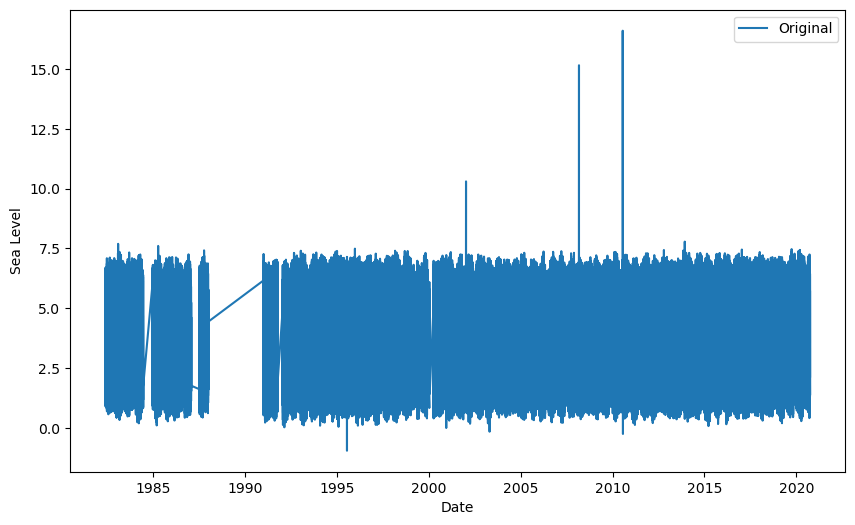

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_hourly has a datetime index
# If not, you can set it using df_hourly.set_index('your_datetime_column', inplace=True)

# Remove rows with missing values
df_hourly_clean = df_hourly.dropna(subset=['sea_level'])

# Calculate the Fourier transform
fft_result = np.fft.fft(df_hourly_clean['sea_level'])
frequencies = np.fft.fftfreq(len(df_hourly_clean['sea_level']))

# Identify the index corresponding to the yearly frequency
yearly_frequency_index = np.where(frequencies > 1/365)[0]

# Remove the yearly component
fft_result[yearly_frequency_index] = 0

# Inverse Fourier transform to get the detrended signal
detrended_signal = np.fft.ifft(fft_result)

# Create a new DataFrame with the detrended signal
df_detrended = pd.DataFrame(index=df_hourly_clean.index)
df_detrended['detrended'] = detrended_signal.real

# Plot the original and detrended signals
plt.figure(figsize=(10, 6))
plt.plot(df_hourly_clean.index, df_hourly_clean['sea_level'], label='Original')
#plt.plot(df_detrended.index, df_detrended['detrended'], label='Detrended (Yearly Scale)')
plt.xlabel('Date')
plt.ylabel('Sea Level')
plt.legend()
plt.show()


In [120]:
import pyextremes
from pyextremes import EVA

In [121]:
# Initialize EVA object
eva_data = df_hourly.sea_level.squeeze()
model = EVA(data=eva_data)
model

/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/pyextremes/eva.py:131: RuntimeWarning: 52,776 Null values found in `data` - removing invalid entries
  warnings.warn(message=message, category=RuntimeWarning)


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     sea_level      Size:                             830,401
Start:                       January 1920      End:                        December 2016
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     sea_level      Size:                             830,401
Start:                       January 1920      End:                        December 2016
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

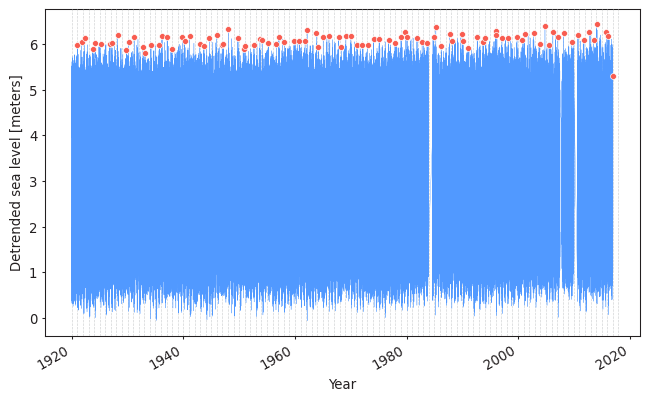

In [123]:
# Extract extreme values by annual block maxima approach
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
print(model)

# Plot block maxima
model.plot_extremes()
plt.xlabel("Year")
plt.ylabel("Detrended sea level [meters]")
#plt.savefig("plots/gev/1_annual_block_maxima.png")
plt.show()

In [125]:
# Fit the model extremes to GEV distribution using MCMC
model.fit_model(
    model="Emcee",
    #model = "MLE", # alternate model 
    distribution="genextreme",
    n_samples = 10_000,
    progress=True
)
print(model)

100%|██████████| 10000/10000 [01:31<00:00, 108.73it/s]


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     sea_level      Size:                             830,401
Start:                       January 1920      End:                        December 2016
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 98      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [126]:
import pickle
# Save model to file
with open("outputs/eva_model.pkl", "wb") as _:
    pickle.dump(model, _)

In [134]:
result_100 = summary.loc[100.0]["return value"]

In [127]:
# Show summary of model return levels
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95
)
summary

/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,return value,lower ci,upper ci
return period,,,
1.0,-inf,NaN,NaN
2.0,6.099675,6.066945,6.132792
5.0,6.228053,6.200724,6.263672
10.0,6.286919,6.262318,6.324771
25.0,6.340650,6.319120,6.382982
50.0,6.369576,6.349972,6.416563
100.0,6.391493,6.373396,6.443249
250.0,6.412672,6.395923,6.470978
500.0,6.424365,6.408218,6.487179


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='sea_level'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='sea_level', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

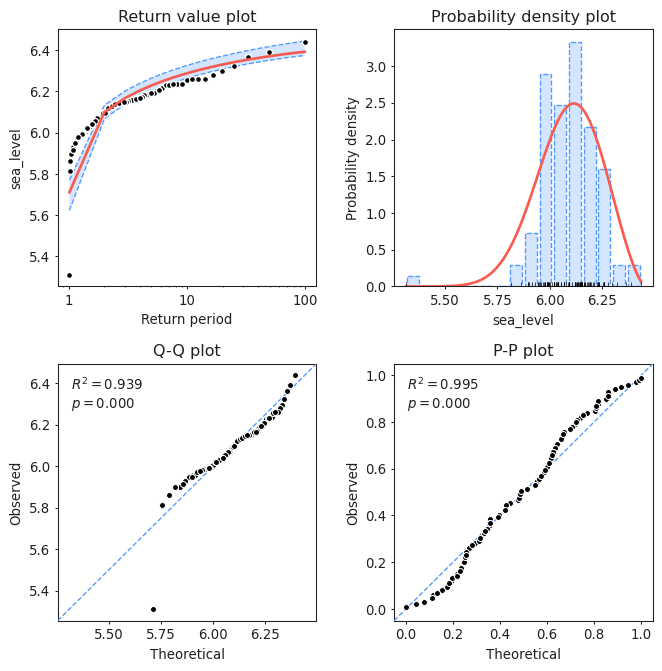

In [128]:
# Diagnostic plot
model.plot_diagnostic(alpha=0.95)